In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

## Machine learning with TensorFlow

So, how do we use all this for machine learning? 

At this point, you're likely ready to move onto any other TensorFlow tutorial you find on the Internet (or in this Github repo). But in case you want to stay here, we'll work our way through a simple example: we'll create a fake dataset of _temperatures_ and _number of hospital visits_ in a fictional city over a number of months. (We assume that colder temperatures lead to more hospital visits.) We'll then fit a linear model to this data. 

The goal of this exercise is for you to see how placeholders, variables, and gradient descent come together to enable fitting a model to some data. Although we'll use a _linear model_ here -- i.e., we assume that the data _y_ can be understood as a linear function of the input $x$ -- the process is the exact same when using a nonlinear model, like a neural network.

### Creating the fake data

Let's begin by creating some fake data for us to train on. We'll make 1000 samples. We generate temperatures according to a normal distribution using `numpy`, then we generate hospital visit numbers according to the formula, `1000 - 5*temps`, plus some random noise.

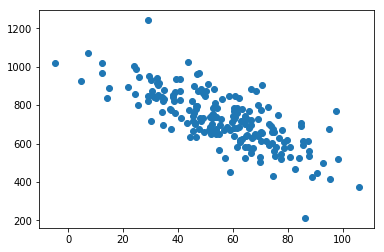

In [43]:
import numpy as np
temps = np.random.normal(55, 20, 1000)
random_noise = np.random.normal(0, 100, 1000)
hosp_visits = 1000 - 5 * temps + random_noise
plt.plot(temps[:200], hosp_visits[:200], "o")

It's common to perform some data cleaning operations on our input data before attempting to use a machine learning algorithm. We'll do that here, subtracting the (empirical) mean and dividing by the standard deviation of the temperature:

In [44]:
normalized_temps = (temps - np.mean(temps)) / np.std(temps)

Now, let's divide the data into training, validation, and test sets.

In [45]:
train_X, train_y = normalized_temps[:800], hosp_visits[:800]
valid_X, valid_y = normalized_temps[800:900], hosp_visits[800:900]
test_X, test_y = normalized_temps[900:], hosp_visits[900:]

Finally, we'll create a "batch generator" for the training set. The following function is a Python _generator function_; instead of returning a value, it continuously _yields_ new batches of data. When we call `batch_generator`, Python creates a _generator iterator_, which we here call `training_generator`, that we can use with Python's `next` function.

In [46]:
def batch_generator(X, y, batch_size):
    total_batches = len(X) // batch_size
    current_batch = 0
    while True:
        start = batch_size * current_batch
        end = start + batch_size
        yield (X[start:end], y[start:end])
        current_batch = (current_batch + 1) % total_batches

training_generator = batch_generator(train_X, train_y, batch_size=100)
# Later, call next(training_generator) to get a new batch of the form (X, y)

### Building the model

Now it's time to build our model. Let's first get a new, empty graph to work with.

In [47]:
tf.reset_default_graph()
g = tf.get_default_graph()

We then set up the major quantities in our model as follows:
1. Our data, the temperatures `X` and the hospital visit numbers `y`, are represented with placeholders. This is so we can fill these values with our actual data at execution time. (You may wonder: why not just put all the data in as a constant? Typically, rather than use Gradient Descent, we use _Stochastic_ Gradient Descent, which means that instead of taking gradients of the loss computed on _all_ our data _every_ iteration, we feed in a small "batch" of data to the graph each iteration of training. This is more efficient, lets us handle large datasets, and provably converges to a local minimum just like normal Gradient Descent. To use this technique, we need placeholders: each time we call `sess.run`, we'll pass in different data.)
2. The parameters of our model, which we hope to _learn_, are represented as TensorFlow variables. This is so that as we run the training operation repeatedly, their current values can change.
3. We then use TensorFlow operations like addition and multiplication to create predicted `y` values based on the `X` values, according to our model. The loss will be computed based on this prediction and its divergence from the true `y`.

In [48]:
X = tf.placeholder(tf.float32)
y = tf.placeholder(tf.float32)
m = tf.Variable(0.)
b = tf.Variable(0.)
predicted_y = X * m + b

### Computing the loss

To compute the loss -- a quantity measuring how bad our model is -- we use sum-of-squares formula: for each data point in the current batch of data, we subtract the real `y` from our `predicted_y` and square the difference; then we take the average of all these. (Taking their sum would work just as well, but by taking the average, we get a number that doesn't depend on the amount of data in a batch, which can be useful for human interpretation and for comparing models with different batch sizes.)

In [49]:
avg_loss = tf.reduce_mean(tf.squared_difference(predicted_y, y))

### Creating an optimizer

Now it's time to actually create our optimization op. We'll use the basic `GradientDescentOptimizer` here, with a learning rate of `0.0005`. (How did we come by this number? Trying different numbers and seeing how the losses looked on the validation set. Feel free to play with this a bit more.)

In [50]:
train_one_step = tf.train.GradientDescentOptimizer(learning_rate=0.0005).minimize(avg_loss)

### Initializing variables and training

Finally, it's time for training. Let's add an op to the graph that initializes all variables, then start a session and run the training code.

In [51]:
init_all_vars = tf.global_variables_initializer()

In [52]:
with tf.Session(config=config) as sess:
    sess.run(init_all_vars)
    for i in range(5000):
        X_batch, y_batch = next(training_generator)
        feed_dict = {X: X_batch, y: y_batch}
        _, loss, m_pred, b_pred = sess.run([train_one_step, avg_loss, m, b], feed_dict=feed_dict)
        if i % 500 == 0:
            validation_feed_dict = {X: valid_X, y: valid_y}
            valid_loss = sess.run(avg_loss, feed_dict=validation_feed_dict)
            print("Iter {}: training loss = {}, validation loss = {}, m={}, b={}".format(i, loss, valid_loss, m_pred, b_pred))
    
    test_feed_dict = {X: test_X, y: test_y}
    m_pred, b_pred, loss = sess.run([m, b, avg_loss], test_feed_dict)
    print("m: {}, b: {}, test loss: {}".format(m_pred, b_pred, loss))

Iter 0: training loss = 547211.375, validation loss = 518814.875, m=-0.03698606789112091, b=0.7282298803329468
Iter 500: training loss = 203055.59375, validation loss = 192593.640625, m=-35.43458557128906, b=285.6358642578125
Iter 1000: training loss = 84924.3828125, validation loss = 73819.1015625, m=-58.61866760253906, b=458.62847900390625
Iter 1500: training loss = 35738.546875, validation loss = 30952.3359375, m=-73.71553802490234, b=563.725341796875
Iter 2000: training loss = 20211.064453125, validation loss = 15739.90234375, m=-83.48970794677734, b=627.5347900390625
Iter 2500: training loss = 13287.3583984375, validation loss = 10489.923828125, m=-89.78942108154297, b=666.3272094726562
Iter 3000: training loss = 10772.7333984375, validation loss = 8779.498046875, m=-93.83386993408203, b=689.8665161132812
Iter 3500: training loss = 10380.283203125, validation loss = 8284.443359375, m=-96.41941833496094, b=704.1984252929688
Iter 4000: training loss = 9264.0361328125, validation los

Because the standard deviation of the noise in our data is 100, we expect the average loss to be no better than $100^2$, which is exactly what we see here. The recovered slope and y-intercept (-100, 729) may look strange to you, but remember that we cleaned our data, which changed the meaning of these parameters. Since we divided temperature values by the standard deviation, approximately 20, a slope of -100 is actually a slope of -5 per degree. And since we subtracted the mean temperature, 55, a y-intercept of 729 is actually a y-intercept of 1004 (that is, $729 + m * \text{mean} = 729 + 5 * 55$).